In [560]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle

In [218]:
scripts_df=pd.read_csv("mystery_movie_data.csv")

In [319]:
scripts_df.columns[:20]

Index(['character', 'movie_title', 'year', 'is_villain', 'raw_dialogue',
       'num_words', 'token_list', 'mean_anger', 'mean_anticipation',
       'mean_disgust', 'mean_fear', 'mean_joy', 'mean_negative',
       'mean_positive', 'mean_sadness', 'mean_surprise', 'mean_trust',
       'embedding_0', 'embedding_1', 'embedding_2'],
      dtype='object')

## Data Analysis 1: How Villian Sentiment Changes Over Time 

In [417]:
anger_fit=LinearRegression().fit(scripts_df[['mean_anger']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
anticipation_fit=LinearRegression().fit(scripts_df[['mean_anticipation']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
disgust_fit=LinearRegression().fit(scripts_df[['mean_disgust']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
fear_fit=LinearRegression().fit(scripts_df[['mean_fear']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
joy_fit=LinearRegression().fit(scripts_df[['mean_joy']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
negative_fit=LinearRegression().fit(scripts_df[['mean_negative']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
positive_fit=LinearRegression().fit(scripts_df[['mean_positive']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
sadness_fit=LinearRegression().fit(scripts_df[['mean_sadness']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
surprise_fit=LinearRegression().fit(scripts_df[['mean_surprise']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])
trust_fit=LinearRegression().fit(scripts_df[['mean_trust']][scripts_df['is_villain']], scripts_df[['year']][scripts_df['is_villain']])

sentiment_by_years=[anger_fit, anticipation_fit, disgust_fit, fear_fit, joy_fit, negative_fit, positive_fit,sadness_fit, surprise_fit, trust_fit]

all_sentiments=scripts_df[['mean_anger', 'mean_anticipation', 'mean_disgust', 'mean_fear', 'mean_joy', 'mean_negative', 'mean_positive', 'mean_sadness', 'mean_surprise', 'mean_trust']][scripts_df['is_villain']]

all_sentiments_by_year=LinearRegression().fit(all_sentiments, scripts_df['year'][scripts_df['is_villain']])

In [418]:
all_sentiments_by_year.score(all_sentiments, scripts_df['year'][scripts_df['is_villain']])

0.3752561881194666

In [404]:
len(scripts_df[scripts_df['year']<1975])

28

In [426]:
reducer=PCA(n_components=2)
X_reduced=reducer.fit_transform(all_sentiments)
reducer.explained_variance_ratio_
X_reduced.shape


(52, 2)

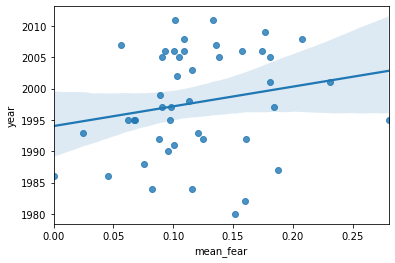

In [413]:
sns.regplot(x=scripts_df['mean_fear'][scripts_df['is_villain']][scripts_df['year']>=1975], y=scripts_df['year'][scripts_df['is_villain']][scripts_df['year']>=1975])

## Data Analysis 2: Intra-archetype Distances vs Inter-archetype Distances and Similarities. 
 

Our second branch of analysis concerns how villains relate to other characters both within their own movies and from across the genre. Specifically, we're interested in how similar or different villains are as an archtype to other characters, and whether they are defined as villains more by the other characters in their movies or by something unique that transcends their own movie.

First, we created a matrix where each row represents a different character and each column represents the occurances of a specific word. Of note is the fact that we restrict our analysis to features (words) that occur in no less than 5 of the characters's scripts and no more than 90% of the characters's scripts (about 244 characters's scripts). We did this to reduce the influence of uninformative features, whether they occur too rarely to be of use or too often to help distinguish between characters. We also normalize by least squares to reduce the influence of extremely long scripts, and use idf weighting for the same purpose.

In [234]:
vectorizer=TfidfVectorizer(
    encoding='utf-8',
    min_df=5,
    max_df=0.9,
    binary=False,
    norm='l2',
    use_idf=True,
    strip_accents='unicode',
    lowercase=True
)
X_scripts=vectorizer.fit_transform(list(scripts_df['raw_dialogue']))

From here we use cosine similarity to measure how how similar each character is to any other. We use cosine similarity instead of other measures such as euclidean distance to further account for differences in script length. We do this both for individual features and for character embeddings (the average of all word vectors a character's spoken)

In [235]:
#get cosine similarities between each character, both in terms of the words in their scripts and their embeddings (cos and cos_embeddings respectively)
cos=cosine_similarity(X_scripts)
embeddings=np.rot90([scripts_df['embedding_'+str(i)] for i in range(300)])[::-1]
cos_embeddings=cosine_similarity(embeddings)

Our study divides characters into one of two types: villains and "others". This isn't to say that there aren't other categories, merely that we're focusing exclusively on how villains relate to other character types. As such we identify three inter-textual (across movies) relationships: villain-villain, villain-other, and other-other. The next bit of code finds the similarities between all characters and groups them by relationship type

In [276]:
# get the positiions of all villains and other characters in the similaritiy matrix
villains_indices=[i for i in range(len(scripts_df)) if scripts_df['is_villain'][i]]
other_indices=[i for i in range(len(scripts_df)) if not(scripts_df['is_villain'][i])]

# set up empty arrays for each of the three types of relationships (villain-villain, villain-other, and other-other) for both word and embeddings
all_villain_villain_similarities=[]
all_other_other_similarities=[]
all_villain_other_similarities=[]
embedding_villain_villain_similarities=[]
embedding_other_other_similarities=[]
embedding_villain_other_similarities=[]

# for each character in the matrix, get their similarities to all other characters and add those similarities to the correct array
for i in range(len(scripts_df)):
    if i in villains_indices:
        for x in range(i+1, len(scripts_df)):
            if x in villains_indices:
                all_villain_villain_similarities.append(cos[i][x])
                embedding_villain_villain_similarities.append(cos_embeddings[i][x])
            elif x in other_indices:
                all_villain_other_similarities.append(cos[i][x])
                embedding_villain_other_similarities.append(cos_embeddings[i][x])
    elif i in other_indices:
        for x in range(i+1, len(scripts_df)):
            if x in other_indices:
                all_other_other_similarities.append(cos[i][x])
                embedding_other_other_similarities.append(cos_embeddings[i][x])

Next we assess inner-textual relationships, how characters relate to other characters in their movies. The next few sections of code gets the similarity both of all characters within their own movies and specifically the villains to other characters in their movies.  

In [277]:
# get the locations in the similaritiy matrix of each movie
movie_ranges=[]

reverse_titles=scripts_df['movie_title'][::-1]

for i in set(scripts_df['movie_title']):
    first_instance=list(scripts_df['movie_title']).index(i)
    last_instance=len(reverse_titles)-1-list(reverse_titles).index(i)
    movie_ranges.append([first_instance, last_instance+1])
movie_ranges.sort()

In [467]:
# collect the similarity of villains to all characters in their movie (villain_movie_similarities and villain_movie_embedding_similarities) and for all characters in a given movie (movie_similarities and movie_embedding_similarities)

movie_similarities=[]
movie_embedding_similarities=[]
for movie in movie_ranges:
    similarities=[]
    embedding_similarities=[]
    for i in range(movie[0], movie[1]):
        for x in range(i, movie[1]):
            if x!=i:
                similarities.append(cos[i][x])
                embedding_similarities.append(cos_embeddings[i][x])
    movie_similarities.append(similarities)
    movie_embedding_similarities.append(embedding_similarities)

villain_movie_similarities=[]
villain_movie_embedding_similarities=[]
for movie in movie_ranges:
    similarities=[]
    embedding_similarities=[]
    for i in range(movie[0], movie[1]):
        if bool(scripts_df.iloc[i]['is_villain']):
            for x in range(movie[0], movie[1]):
                if x!=i:
                    similarities.append(cos[x][i])
                    embedding_similarities.append(cos_embeddings[x][i])
    villain_movie_similarities.append(similarities)
    villain_movie_embedding_similarities.append(embedding_similarities)

movie_similarities=[np.mean(i) for i in movie_similarities if i!=[]]
movie_embedding_similarities=[np.mean(i) for i in movie_embedding_similarities if i!=[]]

villain_movie_similarities=[np.mean(i) for i in villain_movie_similarities if i!=[]]
villain_movie_embedding_similarities=[np.mean(i) for i in villain_movie_embedding_similarities if i!=[]]

Here we get the average similarities for all five groupings

In [468]:
# get the means of all similarities of each type, both for regular and embedded and assign them to variables
intra_villain_similarities=np.mean(villain_movie_similarities)
intra_villain_embedding_similarities=np.mean(villain_movie_embedding_similarities)

intra_movie_similarities=np.mean(movie_similarities)
intra_movie_embedding_similarities=np.mean(movie_embedding_similarities)

inter_other_other=np.mean(all_other_other_similarities)
inter_other_other_embedding=np.mean(embedding_other_other_similarities)

inter_villain_other=np.mean(all_villain_other_similarities)
inter_villain_other_embedding=np.mean(embedding_villain_other_similarities)

inter_villain_villain=np.mean(all_villain_villain_similarities)
inter_villain_villain_embedding=np.mean(embedding_villain_villain_similarities)

inter_all_characters=np.mean(cos)
inter_all_embeddings=np.mean(cos_embeddings)


Here we display our findings. Below we show how similar characters are on average for each of the three key inter-textual relationships (villain-villain, villain-other, and other-other), as well as how similar characters are generally regardless of relationship. We show this for both tokens and embeddings

In [470]:
inter_token_df=pd.DataFrame({"Villain": [inter_villain_other, inter_villain_villain, np.nan], "Other": [inter_other_other, inter_villain_other, np.nan], "All": [np.nan, np.nan, inter_all_characters], "character_type": ['Other', 'Villain', "All"]})
inter_token_df.set_index("character_type")

,Villain,Other,All
character_type,,,
Other,0.220046,0.202193,NaN
Villain,0.244409,0.220046,NaN
All,NaN,NaN,0.212743


In [471]:
inter_embedding_df=pd.DataFrame({"Villain": [inter_villain_other_embedding, inter_villain_villain_embedding, np.nan], "Other": [inter_other_other_embedding, inter_villain_other_embedding, np.nan], "All": [np.nan, np.nan, inter_all_embeddings], "character_type": ['Other', 'Villain', "All"]})
inter_embedding_df.set_index("character_type")

,Villain,Other,All
character_type,,,
Other,0.909875,0.900949,NaN
Villain,0.911772,0.909875,NaN
All,NaN,NaN,0.903325


We also show intra-textual relationships below, both in terms of all characters in a movie and specifically villains to their movie counterparts

In [473]:
intra_df=pd.DataFrame({"Whole-Movie": [intra_movie_similarities, intra_movie_embedding_similarities], "Villain-Movie": [intra_villain_similarities, intra_villain_embedding_similarities], "Metric": ["Token", "Embedding"]}).set_index("Metric")
intra_df.head()

,Whole-Movie,Villain-Movie
Metric,,
Token,0.367985,0.377853
Embedding,0.934572,0.939277


## Significance of Inner vs Intra Textual Similarity

In order to see whether our results actually capture a meaningful difference in similariies across character types, we used a bootstrapping paradigm with 5000 iterations to construct confidence intervals around our base set of similarities. In other words, by resampling with replacement, we can see with 95% certainty where the true mean similarity between characters should be. If the mean similarity of any of the studied relationships falls outside this range, we can be reasonably certain that we did not observe it due to chance and that the measurement is significant. 

A quick note on implimentation. Our similarity matrix represents the similarity of the character labeled on the y axis to the character on the x. This means that the similarity between characters 3 and 4, for example, is equivalent to the similarity between 4 and 3. As such, our similarity matrix is essentially mirrored across the y=-x axis, with every element on the diagonal being equal to one (every character is perfectly similar to itself). To combat this redundancy, we constructed our confidence intervals using a subset of the similarity matrix consisting of the lower triangle below the diagonal. 

In [541]:
%%time
"""
associated arrays:
movie_similarities, movie_embedding_similarities

villain_movie_similarities, villain_movie_embedding_similarities


all_villain_villain_similarities=[]
all_other_other_similarities=[]
all_villain_other_similarities=[]
embedding_villain_villain_similarities=[]
embedding_other_other_similarities=[]
embedding_villain_other_similarities=[]

"""

test_movie_means=[]
test_movie_embedding_means=[]
test_inner_villain_means=[]
test_inner_villain_embedding_means=[]
test_other_other_means=[]
test_other_other_embedding_means=[]
test_villain_villain_means=[]
test_villain_villain_embedding_means=[]
test_villain_other_means=[]
test_villain_other_embedding_means=[]
test_all_means=[]
test_all_embedding_means=[]

lower_indices=np.tril_indices(271, k=-1)

cos_lower=cos[lower_indices]
cos_embedding_lower=cos_embeddings[lower_indices]

for i in range(5000):
    test_movie_means.append(np.mean(random.choices(movie_similarities, k=len(movie_similarities))))
    test_movie_embedding_means.append(np.mean(random.choices(movie_embedding_similarities,k=len(movie_embedding_similarities))))

    test_inner_villain_means.append(np.mean(random.choices(villain_movie_similarities, k=len(villain_movie_similarities))))
    test_inner_villain_embedding_means.append(np.mean(random.choices(villain_movie_embedding_similarities, k=len(villain_movie_embedding_similarities))))

    test_other_other_means.append(np.mean(random.choices(all_other_other_similarities, k=len(all_other_other_similarities))))
    test_other_other_embedding_means.append(np.mean(random.choices(embedding_other_other_similarities, k=len(embedding_other_other_similarities))))

    test_villain_villain_means.append(np.mean(random.choices(all_villain_villain_similarities, k=len(all_villain_villain_similarities))))
    test_villain_villain_embedding_means.append(np.mean(random.choices(embedding_villain_villain_similarities, k=len(embedding_villain_villain_similarities))))

    test_villain_other_means.append(np.mean(random.choices(all_villain_other_similarities, k=len(all_villain_other_similarities))))
    test_villain_other_embedding_means.append(np.mean(random.choices(embedding_villain_other_similarities, k=len(embedding_villain_other_similarities))))

    test_all_means.append(np.mean(random.choices(cos_lower, k=len(cos_lower))))
    test_all_embedding_means.append(np.mean(random.choices(cos_embedding_lower, k=len(cos_embedding_lower))))



Wall time: 12min 42s


Here's just a quick function to simplify visualizations later

In [593]:
def compare_with_confidence(baseline, comparors, labels, title):
    colors=['blue', 'green', 'red', 'purple', 'black', 'orange']
    labels.insert(0, "Confidence Interval")
    labels.insert(0, "Baseline")
    binsizes, _, _= plt.hist(baseline, bins=50)
    plt.vlines(np.quantile(baseline, 0.025), ymin=0, ymax=np.max(binsizes), color='green')
    plt.vlines(np.quantile(baseline, 0.975), ymin=0, ymax=np.max(binsizes), color='green')
    for i in range(len(comparors)):
        plt.vlines(comparors[i], ymin=0, ymax=np.max(binsizes), color=colors[i+2])
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Number of Occurances")
    legend_handles=[Rectangle((0,0), 1, 1, color=colors[c], ec='k') for c in range(len(labels))]
    plt.legend(legend_handles, labels, bbox_to_anchor=(1, 0, 0.45, 1))
    plt.title(title)
    plt.show()


### Test 1: Are Villains More Similar to Other Villains Than Other Characters Across Texts

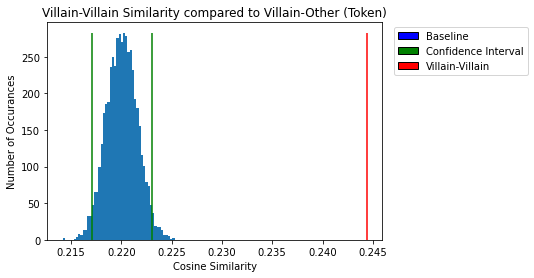

In [597]:
compare_with_confidence(test_villain_other_means, [inter_villain_villain], ['Villain-Villain'], "Villain-Villain Similarity compared to Villain-Other (Token)")

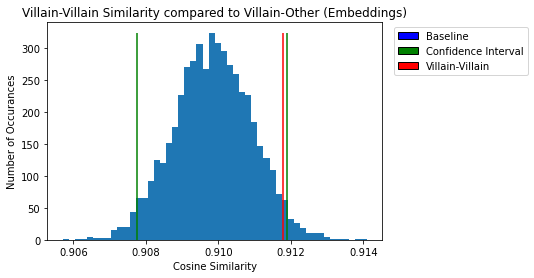

In [600]:
compare_with_confidence(test_villain_other_embedding_means, [inter_villain_villain_embedding], ['Villain-Villain'], "Villain-Villain Similarity compared to Villain-Other (Embeddings)")

SOME EXPLANATION BUT REALLY I HAVE NO IDEA

### Test 2: Are Villains More Similar to Other Characters in their Movies than Villains Across Texts

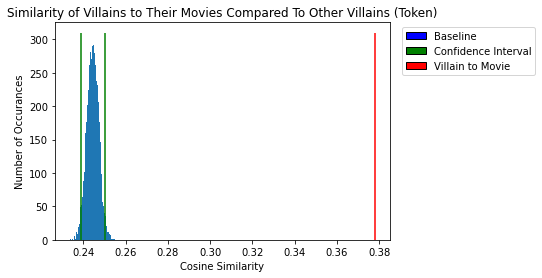

In [603]:
compare_with_confidence(test_villain_villain_means, [intra_villain_similarities], ["Villain to Movie"], "Similarity of Villains to Their Movies Compared To Other Villains (Token)")

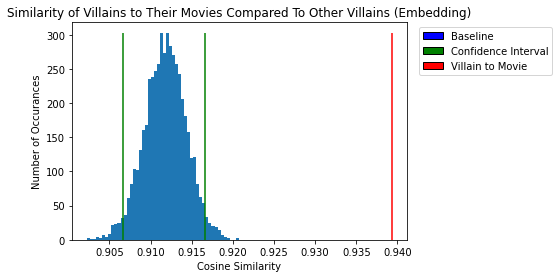

In [604]:
compare_with_confidence(test_villain_villain_embedding_means, [intra_villain_embedding_similarities], ["Villain to Movie"], "Similarity of Villains to Their Movies Compared To Other Villains (Embedding)")

Above the results are striking. Whether one considers the token based measurements or the embedding based ones, villains are significantly more similar to other characters in their movies than they are to villains from other movies. Just how significantly is shown below in terms of standard deviations above the mean

In [610]:
print("Number of standard deviations above the mean (token): {:.2f}".format((intra_villain_similarities - np.mean(test_villain_villain_means))/np.std(test_villain_villain_means)))

print("Number of standard deviations above the mean (embedding): {:.2f}".format((intra_villain_embedding_similarities - np.mean(test_villain_villain_embedding_means))/np.std(test_villain_villain_embedding_means)))

Number of standard deviations above the mean (token): 47.12
Number of standard deviations above the mean (embedding): 10.79


The lower extremity of the embedding's based measurement maskes sense considering the concentration of embeddings towards the upper end of the scale. However, in both cases, the chances that villains are not more similar to other characters in their movies than to other villains across movies is vanishingly small (p<0.01).